# Afriat

In [1]:
ood_seed = 3

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('12', 'Pericentral', 'Uninfected')


Removed datapoint: 408

train         14905
validation     3740
ood             408
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 45%|████▌     | 8615/19053 [00:00<00:00, 86142.48it/s]

 90%|█████████ | 17230/19053 [00:00<00:00, 86063.55it/s]

100%|██████████| 19053/19053 [00:00<00:00, 85858.86it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1001894.04it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 486.31it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:09<1:05:53,  9.91s/it]

Epoch 1/400:   0%|          | 1/400 [00:09<1:05:53,  9.91s/it, v_num=1, recon=3.95e+3, r2_mean=0.207, adv_loss=3.28, acc_pert=0.269, acc_zone=0.736, acc_status_control=0.501]

Epoch 2/400:   0%|          | 1/400 [00:09<1:05:53,  9.91s/it, v_num=1, recon=3.95e+3, r2_mean=0.207, adv_loss=3.28, acc_pert=0.269, acc_zone=0.736, acc_status_control=0.501]

Epoch 2/400:   0%|          | 2/400 [00:18<1:02:15,  9.39s/it, v_num=1, recon=3.95e+3, r2_mean=0.207, adv_loss=3.28, acc_pert=0.269, acc_zone=0.736, acc_status_control=0.501]

Epoch 2/400:   0%|          | 2/400 [00:18<1:02:15,  9.39s/it, v_num=1, recon=3.24e+3, r2_mean=0.612, adv_loss=2.82, acc_pert=0.401, acc_zone=0.83, acc_status_control=0.627] 

Epoch 3/400:   0%|          | 2/400 [00:18<1:02:15,  9.39s/it, v_num=1, recon=3.24e+3, r2_mean=0.612, adv_loss=2.82, acc_pert=0.401, acc_zone=0.83, acc_status_control=0.627]

Epoch 3/400:   1%|          | 3/400 [00:27<59:58,  9.06s/it, v_num=1, recon=3.24e+3, r2_mean=0.612, adv_loss=2.82, acc_pert=0.401, acc_zone=0.83, acc_status_control=0.627]  

Epoch 3/400:   1%|          | 3/400 [00:27<59:58,  9.06s/it, v_num=1, recon=3.19e+3, r2_mean=0.714, adv_loss=2.8, acc_pert=0.388, acc_zone=0.825, acc_status_control=0.608]

Epoch 4/400:   1%|          | 3/400 [00:27<59:58,  9.06s/it, v_num=1, recon=3.19e+3, r2_mean=0.714, adv_loss=2.8, acc_pert=0.388, acc_zone=0.825, acc_status_control=0.608]

Epoch 4/400:   1%|          | 4/400 [00:36<59:06,  8.95s/it, v_num=1, recon=3.19e+3, r2_mean=0.714, adv_loss=2.8, acc_pert=0.388, acc_zone=0.825, acc_status_control=0.608]

Epoch 4/400:   1%|          | 4/400 [00:36<59:06,  8.95s/it, v_num=1, recon=3.17e+3, r2_mean=0.751, adv_loss=2.75, acc_pert=0.401, acc_zone=0.838, acc_status_control=0.609]

Epoch 5/400:   1%|          | 4/400 [00:36<59:06,  8.95s/it, v_num=1, recon=3.17e+3, r2_mean=0.751, adv_loss=2.75, acc_pert=0.401, acc_zone=0.838, acc_status_control=0.609]

Epoch 5/400:   1%|▏         | 5/400 [00:45<58:38,  8.91s/it, v_num=1, recon=3.17e+3, r2_mean=0.751, adv_loss=2.75, acc_pert=0.401, acc_zone=0.838, acc_status_control=0.609]

Epoch 5/400:   1%|▏         | 5/400 [00:45<58:38,  8.91s/it, v_num=1, recon=3.16e+3, r2_mean=0.776, adv_loss=2.52, acc_pert=0.49, acc_zone=0.845, acc_status_control=0.61]  

Epoch 6/400:   1%|▏         | 5/400 [00:45<58:38,  8.91s/it, v_num=1, recon=3.16e+3, r2_mean=0.776, adv_loss=2.52, acc_pert=0.49, acc_zone=0.845, acc_status_control=0.61]

Epoch 6/400:   2%|▏         | 6/400 [00:53<57:58,  8.83s/it, v_num=1, recon=3.16e+3, r2_mean=0.776, adv_loss=2.52, acc_pert=0.49, acc_zone=0.845, acc_status_control=0.61]

Epoch 6/400:   2%|▏         | 6/400 [00:53<57:58,  8.83s/it, v_num=1, recon=3.15e+3, r2_mean=0.79, adv_loss=2.33, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.621]

Epoch 7/400:   2%|▏         | 6/400 [00:53<57:58,  8.83s/it, v_num=1, recon=3.15e+3, r2_mean=0.79, adv_loss=2.33, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.621]

Epoch 7/400:   2%|▏         | 7/400 [01:02<57:44,  8.81s/it, v_num=1, recon=3.15e+3, r2_mean=0.79, adv_loss=2.33, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.621]

Epoch 7/400:   2%|▏         | 7/400 [01:02<57:44,  8.81s/it, v_num=1, recon=3.13e+3, r2_mean=0.8, adv_loss=2.2, acc_pert=0.587, acc_zone=0.85, acc_status_control=0.633]   

Epoch 8/400:   2%|▏         | 7/400 [01:02<57:44,  8.81s/it, v_num=1, recon=3.13e+3, r2_mean=0.8, adv_loss=2.2, acc_pert=0.587, acc_zone=0.85, acc_status_control=0.633]

Epoch 8/400:   2%|▏         | 8/400 [01:11<57:37,  8.82s/it, v_num=1, recon=3.13e+3, r2_mean=0.8, adv_loss=2.2, acc_pert=0.587, acc_zone=0.85, acc_status_control=0.633]

Epoch 8/400:   2%|▏         | 8/400 [01:11<57:37,  8.82s/it, v_num=1, recon=3.13e+3, r2_mean=0.805, adv_loss=2.09, acc_pert=0.627, acc_zone=0.852, acc_status_control=0.637]

Epoch 9/400:   2%|▏         | 8/400 [01:11<57:37,  8.82s/it, v_num=1, recon=3.13e+3, r2_mean=0.805, adv_loss=2.09, acc_pert=0.627, acc_zone=0.852, acc_status_control=0.637]

Epoch 9/400:   2%|▏         | 9/400 [01:20<57:15,  8.79s/it, v_num=1, recon=3.13e+3, r2_mean=0.805, adv_loss=2.09, acc_pert=0.627, acc_zone=0.852, acc_status_control=0.637]

Epoch 9/400:   2%|▏         | 9/400 [01:20<57:15,  8.79s/it, v_num=1, recon=3.12e+3, r2_mean=0.81, adv_loss=2.08, acc_pert=0.639, acc_zone=0.855, acc_status_control=0.633] 

Epoch 10/400:   2%|▏         | 9/400 [01:20<57:15,  8.79s/it, v_num=1, recon=3.12e+3, r2_mean=0.81, adv_loss=2.08, acc_pert=0.639, acc_zone=0.855, acc_status_control=0.633]


disnt_basal = 1.238505222170709

disnt_after = 1.875745523403872

val_r2_mean = 0.8077974270337193

val_r2_var = 0.17522707831520273


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:40<1:19:15, 12.19s/it, v_num=1, recon=3.12e+3, r2_mean=0.81, adv_loss=2.08, acc_pert=0.639, acc_zone=0.855, acc_status_control=0.633]

Epoch 10/400:   2%|▎         | 10/400 [01:40<1:19:15, 12.19s/it, v_num=1, recon=3.11e+3, r2_mean=0.812, adv_loss=2.08, acc_pert=0.648, acc_zone=0.858, acc_status_control=0.625, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:40<1:19:15, 12.19s/it, v_num=1, recon=3.11e+3, r2_mean=0.812, adv_loss=2.08, acc_pert=0.648, acc_zone=0.858, acc_status_control=0.625, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:48<1:12:12, 11.14s/it, v_num=1, recon=3.11e+3, r2_mean=0.812, adv_loss=2.08, acc_pert=0.648, acc_zone=0.858, acc_status_control=0.625, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:48<1:12:12, 11.14s/it, v_num=1, recon=3.11e+3, r2_mean=0.814, adv_loss=2.03, acc_pert=0.663, acc_zone=0.862, acc_status_control=0.632, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [01:48<1:12:12, 11.14s/it, v_num=1, recon=3.11e+3, r2_mean=0.814, adv_loss=2.03, acc_pert=0.663, acc_zone=0.862, acc_status_control=0.632, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:57<1:07:17, 10.41s/it, v_num=1, recon=3.11e+3, r2_mean=0.814, adv_loss=2.03, acc_pert=0.663, acc_zone=0.862, acc_status_control=0.632, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:57<1:07:17, 10.41s/it, v_num=1, recon=3.1e+3, r2_mean=0.82, adv_loss=2, acc_pert=0.669, acc_zone=0.859, acc_status_control=0.629, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]     

Epoch 13/400:   3%|▎         | 12/400 [01:57<1:07:17, 10.41s/it, v_num=1, recon=3.1e+3, r2_mean=0.82, adv_loss=2, acc_pert=0.669, acc_zone=0.859, acc_status_control=0.629, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:06<1:03:53,  9.90s/it, v_num=1, recon=3.1e+3, r2_mean=0.82, adv_loss=2, acc_pert=0.669, acc_zone=0.859, acc_status_control=0.629, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:06<1:03:53,  9.90s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.677, acc_zone=0.861, acc_status_control=0.627, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [02:06<1:03:53,  9.90s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.677, acc_zone=0.861, acc_status_control=0.627, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:15<1:01:32,  9.57s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.677, acc_zone=0.861, acc_status_control=0.627, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:15<1:01:32,  9.57s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=2, acc_pert=0.678, acc_zone=0.863, acc_status_control=0.629, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:15<1:01:32,  9.57s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=2, acc_pert=0.678, acc_zone=0.863, acc_status_control=0.629, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:23<1:00:04,  9.36s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=2, acc_pert=0.678, acc_zone=0.863, acc_status_control=0.629, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:23<1:00:04,  9.36s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.97, acc_pert=0.678, acc_zone=0.863, acc_status_control=0.63, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [02:23<1:00:04,  9.36s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.97, acc_pert=0.678, acc_zone=0.863, acc_status_control=0.63, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:32<58:49,  9.19s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.97, acc_pert=0.678, acc_zone=0.863, acc_status_control=0.63, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]  

Epoch 16/400:   4%|▍         | 16/400 [02:32<58:49,  9.19s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.98, acc_pert=0.682, acc_zone=0.861, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:32<58:49,  9.19s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.98, acc_pert=0.682, acc_zone=0.861, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:41<58:04,  9.10s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.98, acc_pert=0.682, acc_zone=0.861, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:41<58:04,  9.10s/it, v_num=1, recon=3.08e+3, r2_mean=0.826, adv_loss=1.96, acc_pert=0.686, acc_zone=0.862, acc_status_control=0.64, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan] 

Epoch 18/400:   4%|▍         | 17/400 [02:41<58:04,  9.10s/it, v_num=1, recon=3.08e+3, r2_mean=0.826, adv_loss=1.96, acc_pert=0.686, acc_zone=0.862, acc_status_control=0.64, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:50<57:38,  9.05s/it, v_num=1, recon=3.08e+3, r2_mean=0.826, adv_loss=1.96, acc_pert=0.686, acc_zone=0.862, acc_status_control=0.64, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:50<57:38,  9.05s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.96, acc_pert=0.687, acc_zone=0.863, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [02:50<57:38,  9.05s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.96, acc_pert=0.687, acc_zone=0.863, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:59<58:00,  9.14s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.96, acc_pert=0.687, acc_zone=0.863, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:59<58:00,  9.14s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.97, acc_pert=0.688, acc_zone=0.86, acc_status_control=0.638, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan] 

Epoch 20/400:   5%|▍         | 19/400 [02:59<58:00,  9.14s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.97, acc_pert=0.688, acc_zone=0.86, acc_status_control=0.638, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]


disnt_basal = 1.2327714828536276

disnt_after = 1.8570379310745329

val_r2_mean = 0.8178901798063692

val_r2_var = 0.21936187265326312


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [03:17<1:14:44, 11.80s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.97, acc_pert=0.688, acc_zone=0.86, acc_status_control=0.638, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.808, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:17<1:14:44, 11.80s/it, v_num=1, recon=3.07e+3, r2_mean=0.828, adv_loss=1.95, acc_pert=0.691, acc_zone=0.858, acc_status_control=0.642, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [03:17<1:14:44, 11.80s/it, v_num=1, recon=3.07e+3, r2_mean=0.828, adv_loss=1.95, acc_pert=0.691, acc_zone=0.858, acc_status_control=0.642, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:26<1:09:00, 10.92s/it, v_num=1, recon=3.07e+3, r2_mean=0.828, adv_loss=1.95, acc_pert=0.691, acc_zone=0.858, acc_status_control=0.642, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:26<1:09:00, 10.92s/it, v_num=1, recon=3.06e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.686, acc_zone=0.86, acc_status_control=0.642, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [03:26<1:09:00, 10.92s/it, v_num=1, recon=3.06e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.686, acc_zone=0.86, acc_status_control=0.642, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:35<1:05:03, 10.33s/it, v_num=1, recon=3.06e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.686, acc_zone=0.86, acc_status_control=0.642, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:35<1:05:03, 10.33s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.98, acc_pert=0.677, acc_zone=0.857, acc_status_control=0.644, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [03:35<1:05:03, 10.33s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.98, acc_pert=0.677, acc_zone=0.857, acc_status_control=0.644, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:45<1:03:50, 10.16s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.98, acc_pert=0.677, acc_zone=0.857, acc_status_control=0.644, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:45<1:03:50, 10.16s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.95, acc_pert=0.688, acc_zone=0.861, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [03:45<1:03:50, 10.16s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.95, acc_pert=0.688, acc_zone=0.861, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:54<1:01:20,  9.79s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.95, acc_pert=0.688, acc_zone=0.861, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:54<1:01:20,  9.79s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.96, acc_pert=0.684, acc_zone=0.855, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [03:54<1:01:20,  9.79s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.96, acc_pert=0.684, acc_zone=0.855, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [04:03<59:30,  9.52s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.96, acc_pert=0.684, acc_zone=0.855, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]  

Epoch 25/400:   6%|▋         | 25/400 [04:03<59:30,  9.52s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.674, acc_zone=0.857, acc_status_control=0.648, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [04:03<59:30,  9.52s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.674, acc_zone=0.857, acc_status_control=0.648, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [04:12<58:18,  9.35s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.674, acc_zone=0.857, acc_status_control=0.648, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [04:12<58:18,  9.35s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.674, acc_zone=0.856, acc_status_control=0.645, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [04:12<58:18,  9.35s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.674, acc_zone=0.856, acc_status_control=0.645, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:21<57:24,  9.24s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.674, acc_zone=0.856, acc_status_control=0.645, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:21<57:24,  9.24s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.676, acc_zone=0.86, acc_status_control=0.645, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan] 

Epoch 28/400:   7%|▋         | 27/400 [04:21<57:24,  9.24s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.676, acc_zone=0.86, acc_status_control=0.645, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:30<56:36,  9.13s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.676, acc_zone=0.86, acc_status_control=0.645, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:30<56:36,  9.13s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.99, acc_pert=0.671, acc_zone=0.858, acc_status_control=0.642, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [04:30<56:36,  9.13s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.99, acc_pert=0.671, acc_zone=0.858, acc_status_control=0.642, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:39<56:12,  9.09s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.99, acc_pert=0.671, acc_zone=0.858, acc_status_control=0.642, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:39<56:12,  9.09s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.01, acc_pert=0.663, acc_zone=0.856, acc_status_control=0.644, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [04:39<56:12,  9.09s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.01, acc_pert=0.663, acc_zone=0.856, acc_status_control=0.644, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]


disnt_basal = 1.218628654529193

disnt_after = 1.8560299683099284

val_r2_mean = 0.8232355689291657

val_r2_var = 0.2438740462849026


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [04:59<1:17:20, 12.54s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.01, acc_pert=0.663, acc_zone=0.856, acc_status_control=0.644, val_recon=3.09e+3, disnt_basal=1.23, disnt_after=1.86, val_r2_mean=0.818, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [04:59<1:17:20, 12.54s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.01, acc_pert=0.663, acc_zone=0.856, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [04:59<1:17:20, 12.54s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.01, acc_pert=0.663, acc_zone=0.856, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [05:08<1:10:38, 11.49s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.01, acc_pert=0.663, acc_zone=0.856, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [05:08<1:10:38, 11.49s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.02, acc_pert=0.661, acc_zone=0.855, acc_status_control=0.648, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan] 

Epoch 32/400:   8%|▊         | 31/400 [05:08<1:10:38, 11.49s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.02, acc_pert=0.661, acc_zone=0.855, acc_status_control=0.648, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [05:17<1:05:27, 10.67s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.02, acc_pert=0.661, acc_zone=0.855, acc_status_control=0.648, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [05:17<1:05:27, 10.67s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.02, acc_pert=0.659, acc_zone=0.855, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [05:17<1:05:27, 10.67s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.02, acc_pert=0.659, acc_zone=0.855, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:26<1:01:53, 10.12s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.02, acc_pert=0.659, acc_zone=0.855, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:26<1:01:53, 10.12s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.66, acc_zone=0.849, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [05:26<1:01:53, 10.12s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.66, acc_zone=0.849, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:35<59:22,  9.73s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.66, acc_zone=0.849, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]  

Epoch 34/400:   8%|▊         | 34/400 [05:35<59:22,  9.73s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.656, acc_zone=0.853, acc_status_control=0.643, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [05:35<59:22,  9.73s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.656, acc_zone=0.853, acc_status_control=0.643, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:44<57:46,  9.50s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.656, acc_zone=0.853, acc_status_control=0.643, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:44<57:46,  9.50s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.02, acc_pert=0.655, acc_zone=0.854, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [05:44<57:46,  9.50s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.02, acc_pert=0.655, acc_zone=0.854, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:52<56:25,  9.30s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.02, acc_pert=0.655, acc_zone=0.854, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:52<56:25,  9.30s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.655, acc_zone=0.847, acc_status_control=0.646, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [05:52<56:25,  9.30s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.655, acc_zone=0.847, acc_status_control=0.646, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [06:01<55:28,  9.17s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.655, acc_zone=0.847, acc_status_control=0.646, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [06:01<55:28,  9.17s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.04, acc_pert=0.65, acc_zone=0.851, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan] 

Epoch 38/400:   9%|▉         | 37/400 [06:01<55:28,  9.17s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.04, acc_pert=0.65, acc_zone=0.851, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [06:10<54:41,  9.07s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.04, acc_pert=0.65, acc_zone=0.851, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [06:10<54:41,  9.07s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.646, acc_zone=0.85, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [06:10<54:41,  9.07s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.646, acc_zone=0.85, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:19<53:59,  8.97s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.646, acc_zone=0.85, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:19<53:59,  8.97s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.649, acc_zone=0.854, acc_status_control=0.64, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [06:19<53:59,  8.97s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.649, acc_zone=0.854, acc_status_control=0.64, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.2099969810346856

disnt_after = 1.8498696122231755

val_r2_mean = 0.825416306654801

val_r2_var = 0.2522320471208659


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [06:37<1:09:59, 11.67s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.649, acc_zone=0.854, acc_status_control=0.64, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.823, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [06:37<1:09:59, 11.67s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.649, acc_zone=0.851, acc_status_control=0.643, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [06:37<1:09:59, 11.67s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.649, acc_zone=0.851, acc_status_control=0.643, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:46<1:04:38, 10.80s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.649, acc_zone=0.851, acc_status_control=0.643, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:46<1:04:38, 10.80s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.649, acc_zone=0.851, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]   

Epoch 42/400:  10%|█         | 41/400 [06:46<1:04:38, 10.80s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.649, acc_zone=0.851, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:55<1:00:59, 10.22s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.649, acc_zone=0.851, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:55<1:00:59, 10.22s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.07, acc_pert=0.646, acc_zone=0.849, acc_status_control=0.642, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [06:55<1:00:59, 10.22s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.07, acc_pert=0.646, acc_zone=0.849, acc_status_control=0.642, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [07:03<58:15,  9.79s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.07, acc_pert=0.646, acc_zone=0.849, acc_status_control=0.642, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]  

Epoch 43/400:  11%|█         | 43/400 [07:03<58:15,  9.79s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.07, acc_pert=0.641, acc_zone=0.85, acc_status_control=0.643, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan] 

Epoch 44/400:  11%|█         | 43/400 [07:03<58:15,  9.79s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.07, acc_pert=0.641, acc_zone=0.85, acc_status_control=0.643, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [07:12<56:31,  9.53s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.07, acc_pert=0.641, acc_zone=0.85, acc_status_control=0.643, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [07:12<56:31,  9.53s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.08, acc_pert=0.636, acc_zone=0.851, acc_status_control=0.642, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [07:12<56:31,  9.53s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.08, acc_pert=0.636, acc_zone=0.851, acc_status_control=0.642, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [07:21<55:22,  9.36s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.08, acc_pert=0.636, acc_zone=0.851, acc_status_control=0.642, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [07:21<55:22,  9.36s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.07, acc_pert=0.645, acc_zone=0.847, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [07:21<55:22,  9.36s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.07, acc_pert=0.645, acc_zone=0.847, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:30<54:23,  9.22s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.07, acc_pert=0.645, acc_zone=0.847, acc_status_control=0.645, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:30<54:23,  9.22s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.646, acc_zone=0.848, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [07:30<54:23,  9.22s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.646, acc_zone=0.848, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:39<53:44,  9.13s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.646, acc_zone=0.848, acc_status_control=0.644, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:39<53:44,  9.13s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.635, acc_zone=0.851, acc_status_control=0.647, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [07:39<53:44,  9.13s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.635, acc_zone=0.851, acc_status_control=0.647, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:48<53:14,  9.08s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.635, acc_zone=0.851, acc_status_control=0.647, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:48<53:14,  9.08s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.627, acc_zone=0.848, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [07:48<53:14,  9.08s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.627, acc_zone=0.848, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:57<52:47,  9.02s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.627, acc_zone=0.848, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:57<52:47,  9.02s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.634, acc_zone=0.847, acc_status_control=0.646, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [07:57<52:47,  9.02s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.634, acc_zone=0.847, acc_status_control=0.646, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.2098422779595404

disnt_after = 1.8470834821470359

val_r2_mean = 0.8265995489346164

val_r2_var = 0.26155365682905996

Epoch 50/400:  12%|█▎        | 50/400 [08:17<1:12:48, 12.48s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.634, acc_zone=0.847, acc_status_control=0.646, val_recon=3.06e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.825, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [08:17<1:12:48, 12.48s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.624, acc_zone=0.846, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [08:17<1:12:48, 12.48s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.624, acc_zone=0.846, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [08:26<1:06:14, 11.39s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.624, acc_zone=0.846, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [08:26<1:06:14, 11.39s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.624, acc_zone=0.848, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [08:26<1:06:14, 11.39s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.624, acc_zone=0.848, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [08:35<1:01:37, 10.63s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.624, acc_zone=0.848, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [08:35<1:01:37, 10.63s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.632, acc_zone=0.845, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan] 

Epoch 53/400:  13%|█▎        | 52/400 [08:35<1:01:37, 10.63s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.632, acc_zone=0.845, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:44<58:21, 10.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.632, acc_zone=0.845, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]  

Epoch 53/400:  13%|█▎        | 53/400 [08:44<58:21, 10.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.627, acc_zone=0.847, acc_status_control=0.643, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [08:44<58:21, 10.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.627, acc_zone=0.847, acc_status_control=0.643, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:53<55:58,  9.71s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.627, acc_zone=0.847, acc_status_control=0.643, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:53<55:58,  9.71s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.624, acc_zone=0.847, acc_status_control=0.643, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [08:53<55:58,  9.71s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.624, acc_zone=0.847, acc_status_control=0.643, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [09:02<54:17,  9.44s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.624, acc_zone=0.847, acc_status_control=0.643, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [09:02<54:17,  9.44s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.623, acc_zone=0.85, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan] 

Epoch 56/400:  14%|█▍        | 55/400 [09:02<54:17,  9.44s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.623, acc_zone=0.85, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [09:10<53:04,  9.26s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.623, acc_zone=0.85, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [09:10<53:04,  9.26s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.624, acc_zone=0.846, acc_status_control=0.652, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [09:10<53:04,  9.26s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.624, acc_zone=0.846, acc_status_control=0.652, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [09:19<52:06,  9.12s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.624, acc_zone=0.846, acc_status_control=0.652, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [09:19<52:06,  9.12s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.62, acc_zone=0.847, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan] 

Epoch 58/400:  14%|█▍        | 57/400 [09:19<52:06,  9.12s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.62, acc_zone=0.847, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [09:28<51:59,  9.12s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.62, acc_zone=0.847, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [09:28<51:59,  9.12s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.613, acc_zone=0.845, acc_status_control=0.645, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [09:28<51:59,  9.12s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.613, acc_zone=0.845, acc_status_control=0.645, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:38<52:48,  9.29s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.613, acc_zone=0.845, acc_status_control=0.645, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:38<52:48,  9.29s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.14, acc_pert=0.614, acc_zone=0.843, acc_status_control=0.648, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [09:38<52:48,  9.29s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.14, acc_pert=0.614, acc_zone=0.843, acc_status_control=0.648, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.200579755328232

disnt_after = 1.8493557917350814

val_r2_mean = 0.8198280754007983

val_r2_var = 0.2525133995260743


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [09:59<1:13:18, 12.94s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.14, acc_pert=0.614, acc_zone=0.843, acc_status_control=0.648, val_recon=3.03e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [09:59<1:13:18, 12.94s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.611, acc_zone=0.844, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 60/400 [09:59<1:13:18, 12.94s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.611, acc_zone=0.844, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [10:08<1:06:19, 11.74s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.611, acc_zone=0.844, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [10:08<1:06:19, 11.74s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.61, acc_zone=0.843, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan] 

Epoch 62/400:  15%|█▌        | 61/400 [10:08<1:06:19, 11.74s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.61, acc_zone=0.843, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [10:17<1:01:22, 10.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.61, acc_zone=0.843, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [10:17<1:01:22, 10.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.614, acc_zone=0.844, acc_status_control=0.644, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [10:17<1:01:22, 10.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.614, acc_zone=0.844, acc_status_control=0.644, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [10:26<57:55, 10.31s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.614, acc_zone=0.844, acc_status_control=0.644, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]  

Epoch 63/400:  16%|█▌        | 63/400 [10:26<57:55, 10.31s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.606, acc_zone=0.843, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [10:26<57:55, 10.31s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.606, acc_zone=0.843, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [10:35<55:24,  9.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.606, acc_zone=0.843, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [10:35<55:24,  9.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.606, acc_zone=0.847, acc_status_control=0.643, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [10:35<55:24,  9.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.606, acc_zone=0.847, acc_status_control=0.643, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:44<53:36,  9.60s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.606, acc_zone=0.847, acc_status_control=0.643, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:44<53:36,  9.60s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.609, acc_zone=0.843, acc_status_control=0.646, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [10:44<53:36,  9.60s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.609, acc_zone=0.843, acc_status_control=0.646, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:53<52:14,  9.38s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.609, acc_zone=0.843, acc_status_control=0.646, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:53<52:14,  9.38s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.603, acc_zone=0.843, acc_status_control=0.643, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [10:53<52:14,  9.38s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.603, acc_zone=0.843, acc_status_control=0.643, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [11:02<50:58,  9.19s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.603, acc_zone=0.843, acc_status_control=0.643, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [11:02<50:58,  9.19s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.6, acc_zone=0.844, acc_status_control=0.644, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]  

Epoch 68/400:  17%|█▋        | 67/400 [11:02<50:58,  9.19s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.6, acc_zone=0.844, acc_status_control=0.644, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [11:11<50:15,  9.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.6, acc_zone=0.844, acc_status_control=0.644, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [11:11<50:15,  9.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.6, acc_zone=0.842, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [11:11<50:15,  9.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.6, acc_zone=0.842, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [11:19<49:36,  8.99s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.6, acc_zone=0.842, acc_status_control=0.645, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [11:19<49:36,  8.99s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.602, acc_zone=0.844, acc_status_control=0.646, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [11:19<49:36,  8.99s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.602, acc_zone=0.844, acc_status_control=0.646, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]


disnt_basal = 1.1877530416941786

disnt_after = 1.8479945706356178

val_r2_mean = 0.828685810558245

val_r2_var = 0.25792674395231746


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [11:39<1:07:19, 12.24s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.602, acc_zone=0.844, acc_status_control=0.646, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.82, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [11:39<1:07:19, 12.24s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.601, acc_zone=0.839, acc_status_control=0.644, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [11:39<1:07:19, 12.24s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.601, acc_zone=0.839, acc_status_control=0.644, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:48<1:01:35, 11.23s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.601, acc_zone=0.839, acc_status_control=0.644, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:48<1:01:35, 11.23s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.599, acc_zone=0.839, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [11:48<1:01:35, 11.23s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.599, acc_zone=0.839, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:57<57:57, 10.60s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.599, acc_zone=0.839, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]  

Epoch 72/400:  18%|█▊        | 72/400 [11:57<57:57, 10.60s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.605, acc_zone=0.844, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan] 

Epoch 73/400:  18%|█▊        | 72/400 [11:57<57:57, 10.60s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.605, acc_zone=0.844, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [12:06<55:08, 10.12s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.605, acc_zone=0.844, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [12:06<55:08, 10.12s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.19, acc_pert=0.597, acc_zone=0.842, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [12:06<55:08, 10.12s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.19, acc_pert=0.597, acc_zone=0.842, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [12:15<53:09,  9.79s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.19, acc_pert=0.597, acc_zone=0.842, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [12:15<53:09,  9.79s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.605, acc_zone=0.84, acc_status_control=0.644, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [12:15<53:09,  9.79s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.605, acc_zone=0.84, acc_status_control=0.644, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [12:24<51:53,  9.58s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.605, acc_zone=0.84, acc_status_control=0.644, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [12:24<51:53,  9.58s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.593, acc_zone=0.843, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [12:24<51:53,  9.58s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.593, acc_zone=0.843, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [12:33<50:41,  9.39s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.593, acc_zone=0.843, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [12:33<50:41,  9.39s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.601, acc_zone=0.839, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [12:33<50:41,  9.39s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.601, acc_zone=0.839, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [12:42<49:59,  9.29s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.601, acc_zone=0.839, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [12:42<49:59,  9.29s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.595, acc_zone=0.842, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan] 

Epoch 78/400:  19%|█▉        | 77/400 [12:42<49:59,  9.29s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.595, acc_zone=0.842, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:52<49:57,  9.31s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.595, acc_zone=0.842, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:52<49:57,  9.31s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.597, acc_zone=0.843, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [12:52<49:57,  9.31s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.597, acc_zone=0.843, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [13:01<49:10,  9.19s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.597, acc_zone=0.843, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [13:01<49:10,  9.19s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.594, acc_zone=0.84, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan] 

Epoch 80/400:  20%|█▉        | 79/400 [13:01<49:10,  9.19s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.594, acc_zone=0.84, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2114051042786471

disnt_after = 1.8717641852799667

val_r2_mean = 0.8297946235950924

val_r2_var = 0.2643107995917987


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [13:20<1:05:12, 12.23s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.594, acc_zone=0.84, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [13:20<1:05:12, 12.23s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.594, acc_zone=0.843, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [13:20<1:05:12, 12.23s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.594, acc_zone=0.843, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [13:29<59:26, 11.18s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.594, acc_zone=0.843, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]  

Epoch 81/400:  20%|██        | 81/400 [13:29<59:26, 11.18s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.587, acc_zone=0.838, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [13:29<59:26, 11.18s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.587, acc_zone=0.838, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [13:38<56:19, 10.63s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.587, acc_zone=0.838, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [13:38<56:19, 10.63s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.594, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [13:38<56:19, 10.63s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.594, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [13:47<53:13, 10.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.594, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [13:47<53:13, 10.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.588, acc_zone=0.842, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 84/400:  21%|██        | 83/400 [13:47<53:13, 10.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.588, acc_zone=0.842, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:55<51:02,  9.69s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.588, acc_zone=0.842, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:55<51:02,  9.69s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.585, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [13:56<51:02,  9.69s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.585, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [14:04<49:22,  9.40s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.585, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [14:04<49:22,  9.40s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.583, acc_zone=0.845, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [14:04<49:22,  9.40s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.583, acc_zone=0.845, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [14:13<48:11,  9.21s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.583, acc_zone=0.845, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [14:13<48:11,  9.21s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.587, acc_zone=0.84, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [14:13<48:11,  9.21s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.587, acc_zone=0.84, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [14:22<47:41,  9.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.587, acc_zone=0.84, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [14:22<47:41,  9.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.586, acc_zone=0.839, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [14:22<47:41,  9.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.586, acc_zone=0.839, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [14:31<47:08,  9.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.586, acc_zone=0.839, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [14:31<47:08,  9.07s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.591, acc_zone=0.841, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 89/400:  22%|██▏       | 88/400 [14:31<47:08,  9.07s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.591, acc_zone=0.841, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [14:40<46:53,  9.05s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.591, acc_zone=0.841, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [14:40<46:53,  9.05s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.587, acc_zone=0.837, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [14:40<46:53,  9.05s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.587, acc_zone=0.837, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.187450094590994

disnt_after = 1.849723234220322

val_r2_mean = 0.8319913360397018

val_r2_var = 0.2780717594374161


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [14:58<1:01:14, 11.85s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.587, acc_zone=0.837, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [14:58<1:01:14, 11.85s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.573, acc_zone=0.841, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [14:58<1:01:14, 11.85s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.573, acc_zone=0.841, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [15:08<57:18, 11.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.573, acc_zone=0.841, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]  

Epoch 91/400:  23%|██▎       | 91/400 [15:08<57:18, 11.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.581, acc_zone=0.841, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [15:08<57:18, 11.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.581, acc_zone=0.841, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [15:17<53:49, 10.48s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.581, acc_zone=0.841, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [15:17<53:49, 10.48s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.586, acc_zone=0.839, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [15:17<53:49, 10.48s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.586, acc_zone=0.839, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [15:26<51:18, 10.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.586, acc_zone=0.839, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [15:26<51:18, 10.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [15:26<51:18, 10.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [15:35<49:26,  9.69s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [15:35<49:26,  9.69s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.587, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [15:35<49:26,  9.69s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.587, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [15:43<47:54,  9.43s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.587, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [15:43<47:54,  9.43s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan] 

Epoch 96/400:  24%|██▍       | 95/400 [15:43<47:54,  9.43s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [15:52<46:50,  9.24s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [15:52<46:50,  9.24s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [15:52<46:50,  9.24s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [16:01<46:05,  9.13s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [16:01<46:05,  9.13s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.582, acc_zone=0.839, acc_status_control=0.649, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [16:01<46:05,  9.13s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.582, acc_zone=0.839, acc_status_control=0.649, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [16:10<45:34,  9.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.582, acc_zone=0.839, acc_status_control=0.649, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [16:10<45:34,  9.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan] 

Epoch 99/400:  24%|██▍       | 98/400 [16:10<45:34,  9.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [16:19<45:01,  8.98s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [16:19<45:01,  8.98s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [16:19<45:01,  8.98s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1839980374484322

disnt_after = 1.8567621329143464

val_r2_mean = 0.8265652232259093

val_r2_var = 0.26751344575103514


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [16:42<1:06:07, 13.22s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [16:42<1:06:07, 13.22s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [16:42<1:06:07, 13.22s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [16:51<59:28, 11.94s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]  

Epoch 101/400:  25%|██▌       | 101/400 [16:51<59:28, 11.94s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 102/400:  25%|██▌       | 101/400 [16:51<59:28, 11.94s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [17:00<54:48, 11.03s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [17:00<54:48, 11.03s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [17:00<54:48, 11.03s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [17:09<51:31, 10.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [17:09<51:31, 10.41s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [17:09<51:31, 10.41s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [17:18<49:10,  9.97s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [17:18<49:10,  9.97s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [17:18<49:10,  9.97s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [17:26<47:26,  9.65s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [17:26<47:26,  9.65s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.578, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [17:26<47:26,  9.65s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.578, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [17:35<46:09,  9.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.578, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [17:35<46:09,  9.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [17:35<46:09,  9.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [17:44<45:04,  9.23s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [17:44<45:04,  9.23s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.576, acc_zone=0.84, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 108/400:  27%|██▋       | 107/400 [17:44<45:04,  9.23s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.576, acc_zone=0.84, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [17:53<44:52,  9.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.576, acc_zone=0.84, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [17:53<44:52,  9.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [17:53<44:52,  9.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [18:02<44:07,  9.10s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [18:02<44:07,  9.10s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.571, acc_zone=0.84, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [18:02<44:07,  9.10s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.571, acc_zone=0.84, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1843111292177408

disnt_after = 1.8467016736857078

val_r2_mean = 0.8297982709223799

val_r2_var = 0.27029131519576144

Epoch 110/400:  28%|██▊       | 110/400 [18:22<59:33, 12.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.571, acc_zone=0.84, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [18:22<59:33, 12.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.574, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [18:22<59:33, 12.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.574, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [18:31<54:18, 11.28s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.574, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [18:31<54:18, 11.28s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [18:31<54:18, 11.28s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [18:40<50:38, 10.55s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [18:40<50:38, 10.55s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.574, acc_zone=0.838, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 113/400:  28%|██▊       | 112/400 [18:40<50:38, 10.55s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.574, acc_zone=0.838, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [18:49<48:01, 10.04s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.574, acc_zone=0.838, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [18:49<48:01, 10.04s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [18:49<48:01, 10.04s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [18:57<46:07,  9.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [18:57<46:07,  9.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [18:57<46:07,  9.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [19:06<44:48,  9.43s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [19:06<44:48,  9.43s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.576, acc_zone=0.838, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [19:06<44:48,  9.43s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.576, acc_zone=0.838, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [19:15<43:48,  9.26s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.576, acc_zone=0.838, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [19:15<43:48,  9.26s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [19:15<43:48,  9.26s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [19:24<43:02,  9.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [19:24<43:02,  9.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.578, acc_zone=0.84, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 118/400:  29%|██▉       | 117/400 [19:24<43:02,  9.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.578, acc_zone=0.84, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [19:33<42:34,  9.06s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.578, acc_zone=0.84, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [19:33<42:34,  9.06s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.57, acc_zone=0.841, acc_status_control=0.645, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [19:33<42:34,  9.06s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.57, acc_zone=0.841, acc_status_control=0.645, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [19:42<42:17,  9.03s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.57, acc_zone=0.841, acc_status_control=0.645, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [19:42<42:17,  9.03s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [19:42<42:17,  9.03s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1717286489904721

disnt_after = 1.8480996618863843

val_r2_mean = 0.8302072063957096

val_r2_var = 0.28667304195976373


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [20:03<58:51, 12.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [20:03<58:51, 12.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [20:03<58:51, 12.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [20:12<53:30, 11.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [20:12<53:30, 11.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.577, acc_zone=0.837, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [20:12<53:30, 11.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.577, acc_zone=0.837, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [20:21<49:42, 10.73s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.577, acc_zone=0.837, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [20:21<49:42, 10.73s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.838, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [20:21<49:42, 10.73s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.838, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [20:29<46:55, 10.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.838, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [20:29<46:55, 10.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [20:29<46:55, 10.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [20:38<44:57,  9.77s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [20:38<44:57,  9.77s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [20:38<44:57,  9.77s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [20:47<43:30,  9.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [20:47<43:30,  9.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [20:47<43:30,  9.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [20:56<42:24,  9.29s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [20:56<42:24,  9.29s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [20:56<42:24,  9.29s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [21:05<41:37,  9.15s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [21:05<41:37,  9.15s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.574, acc_zone=0.839, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [21:05<41:37,  9.15s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.574, acc_zone=0.839, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [21:14<40:57,  9.03s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.574, acc_zone=0.839, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [21:14<40:57,  9.03s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 129/400:  32%|███▏      | 128/400 [21:14<40:57,  9.03s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [21:22<40:17,  8.92s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [21:22<40:17,  8.92s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [21:22<40:17,  8.92s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1739131452743528

disnt_after = 1.8378425440518378

val_r2_mean = 0.8309031165546414

val_r2_var = 0.28129155785482923

Epoch 130/400:  32%|███▎      | 130/400 [21:44<57:38, 12.81s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [21:44<57:38, 12.81s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [21:44<57:38, 12.81s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [21:53<51:57, 11.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [21:53<51:57, 11.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.574, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [21:53<51:57, 11.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.574, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [22:02<48:10, 10.79s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.574, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [22:02<48:10, 10.79s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan] 

Epoch 133/400:  33%|███▎      | 132/400 [22:02<48:10, 10.79s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [22:11<45:30, 10.23s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [22:11<45:30, 10.23s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [22:11<45:30, 10.23s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [22:20<43:35,  9.83s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [22:20<43:35,  9.83s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [22:20<43:35,  9.83s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [22:29<42:16,  9.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [22:29<42:16,  9.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.575, acc_zone=0.839, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [22:29<42:16,  9.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.575, acc_zone=0.839, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [22:38<41:26,  9.42s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.575, acc_zone=0.839, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [22:38<41:26,  9.42s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]  

Epoch 137/400:  34%|███▍      | 136/400 [22:38<41:26,  9.42s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [22:46<40:27,  9.23s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [22:46<40:27,  9.23s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.572, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [22:46<40:27,  9.23s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.572, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [22:55<39:41,  9.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.572, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [22:55<39:41,  9.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan] 

Epoch 139/400:  34%|███▍      | 138/400 [22:55<39:41,  9.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [23:04<39:13,  9.02s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [23:04<39:13,  9.02s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.578, acc_zone=0.839, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [23:04<39:13,  9.02s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.578, acc_zone=0.839, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1791516709473562

disnt_after = 1.8422445700781698

val_r2_mean = 0.8337568144379991

val_r2_var = 0.2855746069851042

Epoch 140/400:  35%|███▌      | 140/400 [23:25<54:11, 12.50s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.578, acc_zone=0.839, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [23:25<54:11, 12.50s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.57, acc_zone=0.839, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [23:25<54:11, 12.50s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.57, acc_zone=0.839, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [23:33<49:07, 11.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.57, acc_zone=0.839, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [23:33<49:07, 11.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [23:33<49:07, 11.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [23:42<45:36, 10.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [23:42<45:36, 10.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [23:42<45:36, 10.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [23:51<43:19, 10.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [23:51<43:19, 10.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [23:51<43:19, 10.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [24:00<41:21,  9.69s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [24:00<41:21,  9.69s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [24:00<41:21,  9.69s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [24:09<40:02,  9.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [24:09<40:02,  9.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [24:09<40:02,  9.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [24:17<39:00,  9.21s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [24:17<39:00,  9.21s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 147/400:  36%|███▋      | 146/400 [24:17<39:00,  9.21s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [24:26<38:18,  9.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [24:26<38:18,  9.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [24:26<38:18,  9.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [24:35<37:38,  8.96s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [24:35<37:38,  8.96s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [24:35<37:38,  8.96s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [24:44<37:21,  8.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [24:44<37:21,  8.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]  

Epoch 150/400:  37%|███▋      | 149/400 [24:44<37:21,  8.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.174176794295975

disnt_after = 1.837778302961192

val_r2_mean = 0.828852026442348

val_r2_var = 0.2852112978353113

Epoch 150/400:  38%|███▊      | 150/400 [25:07<55:23, 13.29s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [25:07<55:23, 13.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [25:07<55:23, 13.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [25:16<49:36, 11.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [25:16<49:36, 11.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [25:16<49:36, 11.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [25:25<45:24, 10.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [25:25<45:24, 10.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [25:25<45:24, 10.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [25:33<42:28, 10.32s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [25:33<42:28, 10.32s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [25:34<42:28, 10.32s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [25:42<40:25,  9.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [25:42<40:25,  9.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [25:42<40:25,  9.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [25:51<39:24,  9.65s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [25:51<39:24,  9.65s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [25:51<39:24,  9.65s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [26:00<38:19,  9.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [26:00<38:19,  9.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [26:00<38:19,  9.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [26:09<37:29,  9.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [26:09<37:29,  9.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [26:09<37:29,  9.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [26:18<36:50,  9.14s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [26:18<36:50,  9.14s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [26:18<36:50,  9.14s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [26:27<36:15,  9.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [26:27<36:15,  9.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]  

Epoch 160/400:  40%|███▉      | 159/400 [26:27<36:15,  9.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.177646628157112

disnt_after = 1.837858954120827

val_r2_mean = 0.8254727286826564

val_r2_var = 0.2748130396804382

Epoch 160/400:  40%|████      | 160/400 [26:44<45:51, 11.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [26:44<45:51, 11.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.837, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [26:44<45:51, 11.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.837, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [26:53<42:18, 10.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.837, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [26:53<42:18, 10.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [26:53<42:18, 10.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [27:01<39:54, 10.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [27:01<39:54, 10.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [27:01<39:54, 10.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [27:10<38:08,  9.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [27:10<38:08,  9.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [27:10<38:08,  9.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [27:19<36:53,  9.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [27:19<36:53,  9.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [27:19<36:53,  9.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [27:28<35:53,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [27:28<35:53,  9.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [27:28<35:53,  9.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [27:36<35:13,  9.03s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [27:36<35:13,  9.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [27:36<35:13,  9.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [27:45<34:41,  8.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [27:45<34:41,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan] 

Epoch 168/400:  42%|████▏     | 167/400 [27:45<34:41,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [27:54<34:11,  8.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [27:54<34:11,  8.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [27:54<34:11,  8.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [28:02<33:49,  8.79s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [28:02<33:49,  8.79s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [28:02<33:49,  8.79s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1631217724417902

disnt_after = 1.8299223002283038

val_r2_mean = 0.8289182799062312

val_r2_var = 0.29458202179665277

Epoch 170/400:  42%|████▎     | 170/400 [28:23<47:43, 12.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [28:23<47:43, 12.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [28:23<47:43, 12.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [28:32<43:15, 11.33s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [28:32<43:15, 11.33s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.57, acc_zone=0.843, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 172/400:  43%|████▎     | 171/400 [28:32<43:15, 11.33s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.57, acc_zone=0.843, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [28:41<40:05, 10.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.57, acc_zone=0.843, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [28:41<40:05, 10.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [28:41<40:05, 10.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [28:49<37:51, 10.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [28:49<37:51, 10.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.571, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [28:49<37:51, 10.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.571, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [28:58<36:18,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.571, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [28:58<36:18,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 175/400:  44%|████▎     | 174/400 [28:58<36:18,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [29:07<35:09,  9.38s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [29:07<35:09,  9.38s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [29:07<35:09,  9.38s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [29:16<34:15,  9.18s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [29:16<34:15,  9.18s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [29:16<34:15,  9.18s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [29:24<33:42,  9.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [29:24<33:42,  9.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [29:24<33:42,  9.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [29:33<33:26,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [29:33<33:26,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 179/400:  44%|████▍     | 178/400 [29:33<33:26,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [29:42<33:04,  8.98s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [29:42<33:04,  8.98s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [29:42<33:04,  8.98s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.1742240255575844

disnt_after = 1.8315962243966333

val_r2_mean = 0.8317504420970625

val_r2_var = 0.28515014292316176

Epoch 180/400:  45%|████▌     | 180/400 [30:02<44:17, 12.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [30:02<44:17, 12.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [30:02<44:17, 12.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [30:10<40:33, 11.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [30:10<40:33, 11.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [30:10<40:33, 11.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [30:19<37:54, 10.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [30:19<37:54, 10.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.565, acc_zone=0.839, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [30:19<37:54, 10.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.565, acc_zone=0.839, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [30:28<35:57,  9.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.565, acc_zone=0.839, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [30:28<35:57,  9.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.573, acc_zone=0.837, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [30:28<35:57,  9.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.573, acc_zone=0.837, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [30:37<34:34,  9.60s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.573, acc_zone=0.837, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [30:37<34:34,  9.60s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [30:37<34:34,  9.60s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [30:46<33:31,  9.36s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [30:46<33:31,  9.36s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.574, acc_zone=0.837, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [30:46<33:31,  9.36s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.574, acc_zone=0.837, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [30:55<32:50,  9.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.574, acc_zone=0.837, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [30:55<32:50,  9.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [30:55<32:50,  9.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [31:03<32:14,  9.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [31:03<32:14,  9.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [31:03<32:14,  9.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [31:12<31:46,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [31:12<31:46,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 189/400:  47%|████▋     | 188/400 [31:12<31:46,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [31:21<31:26,  8.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [31:21<31:26,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.573, acc_zone=0.84, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [31:21<31:26,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.573, acc_zone=0.84, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.164177028904471

disnt_after = 1.8287896480436083

val_r2_mean = 0.8289691193811864

val_r2_var = 0.28280514624023423

Epoch 190/400:  48%|████▊     | 190/400 [31:41<43:27, 12.42s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.573, acc_zone=0.84, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [31:41<43:27, 12.42s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [31:41<43:27, 12.42s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [31:50<39:24, 11.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [31:50<39:24, 11.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [31:50<39:24, 11.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [31:59<36:37, 10.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [31:59<36:37, 10.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [31:59<36:37, 10.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [32:08<34:54, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [32:08<34:54, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [32:08<34:54, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [32:17<33:24,  9.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [32:17<33:24,  9.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [32:17<33:24,  9.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [32:26<32:23,  9.48s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [32:26<32:23,  9.48s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [32:26<32:23,  9.48s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [32:35<31:37,  9.30s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [32:35<31:37,  9.30s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [32:35<31:37,  9.30s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [32:44<30:59,  9.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [32:44<30:59,  9.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 198/400:  49%|████▉     | 197/400 [32:44<30:59,  9.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [32:52<30:27,  9.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [32:52<30:27,  9.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [32:52<30:27,  9.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [33:01<30:07,  8.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [33:01<30:07,  8.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [33:01<30:07,  8.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.166947106836445

disnt_after = 1.8272690721566567

val_r2_mean = 0.8288679121233178

val_r2_var = 0.27844475041754996

Epoch 200/400:  50%|█████     | 200/400 [33:22<42:03, 12.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [33:22<42:03, 12.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [33:22<42:03, 12.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [33:31<38:00, 11.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [33:31<38:00, 11.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 202/400:  50%|█████     | 201/400 [33:31<38:00, 11.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [33:40<35:08, 10.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [33:40<35:08, 10.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [33:40<35:08, 10.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [33:49<33:09, 10.10s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [33:49<33:09, 10.10s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [33:49<33:09, 10.10s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [33:57<31:38,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [33:57<31:38,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [33:57<31:38,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [34:06<30:29,  9.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [34:06<30:29,  9.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.567, acc_zone=0.842, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [34:06<30:29,  9.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.567, acc_zone=0.842, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [34:15<29:46,  9.21s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.567, acc_zone=0.842, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [34:15<29:46,  9.21s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [34:15<29:46,  9.21s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [34:24<29:09,  9.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [34:24<29:09,  9.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [34:24<29:09,  9.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [34:32<28:45,  8.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [34:32<28:45,  8.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.557, acc_zone=0.837, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [34:32<28:45,  8.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.557, acc_zone=0.837, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [34:41<28:28,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.557, acc_zone=0.837, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [34:41<28:28,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [34:41<28:28,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.1657152475253685

disnt_after = 1.8301502360376394

val_r2_mean = 0.8226031597476919

val_r2_var = 0.281115350879955

Epoch 210/400:  52%|█████▎    | 210/400 [35:04<41:30, 13.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [35:04<41:30, 13.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [35:04<41:30, 13.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [35:13<37:40, 11.96s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [35:13<37:40, 11.96s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan] 

Epoch 212/400:  53%|█████▎    | 211/400 [35:13<37:40, 11.96s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [35:22<34:28, 11.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [35:22<34:28, 11.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [35:22<34:28, 11.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [35:31<32:09, 10.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [35:31<32:09, 10.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [35:31<32:09, 10.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [35:40<30:30,  9.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [35:40<30:30,  9.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [35:40<30:30,  9.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [35:48<29:20,  9.52s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [35:48<29:20,  9.52s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [35:48<29:20,  9.52s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [35:57<28:32,  9.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [35:57<28:32,  9.31s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [35:57<28:32,  9.31s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [36:06<27:53,  9.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [36:06<27:53,  9.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [36:06<27:53,  9.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [36:15<27:21,  9.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [36:15<27:21,  9.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.567, acc_zone=0.835, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [36:15<27:21,  9.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.567, acc_zone=0.835, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [36:23<26:57,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.567, acc_zone=0.835, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [36:23<26:57,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.567, acc_zone=0.84, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan] 

Epoch 220/400:  55%|█████▍    | 219/400 [36:23<26:57,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.567, acc_zone=0.84, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.1650970491345782

disnt_after = 1.8154955128214147

val_r2_mean = 0.8285855037363631

val_r2_var = 0.29945542974804246

Epoch 220/400:  55%|█████▌    | 220/400 [36:41<34:26, 11.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.567, acc_zone=0.84, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [36:41<34:26, 11.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [36:41<30:01, 10.01s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 1/596 [00:00<03:23,  2.93it/s]

  7%|▋         | 44/596 [00:00<00:04, 128.67it/s]

 14%|█▍        | 85/596 [00:00<00:02, 211.25it/s]

 21%|██▏       | 128/596 [00:00<00:01, 275.37it/s]

 29%|██▉       | 173/596 [00:00<00:01, 326.24it/s]

 37%|███▋      | 218/596 [00:00<00:01, 361.03it/s]

 43%|████▎     | 259/596 [00:01<00:01, 280.91it/s]

 51%|█████     | 304/596 [00:01<00:00, 320.45it/s]

 59%|█████▊    | 349/596 [00:01<00:00, 352.35it/s]

 66%|██████▋   | 395/596 [00:01<00:00, 379.16it/s]

 74%|███████▍  | 441/596 [00:01<00:00, 399.15it/s]

 82%|████████▏ | 486/596 [00:01<00:00, 411.29it/s]

 89%|████████▉ | 533/596 [00:01<00:00, 426.08it/s]

 97%|█████████▋| 580/596 [00:01<00:00, 438.08it/s]

100%|██████████| 596/596 [00:01<00:00, 329.90it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

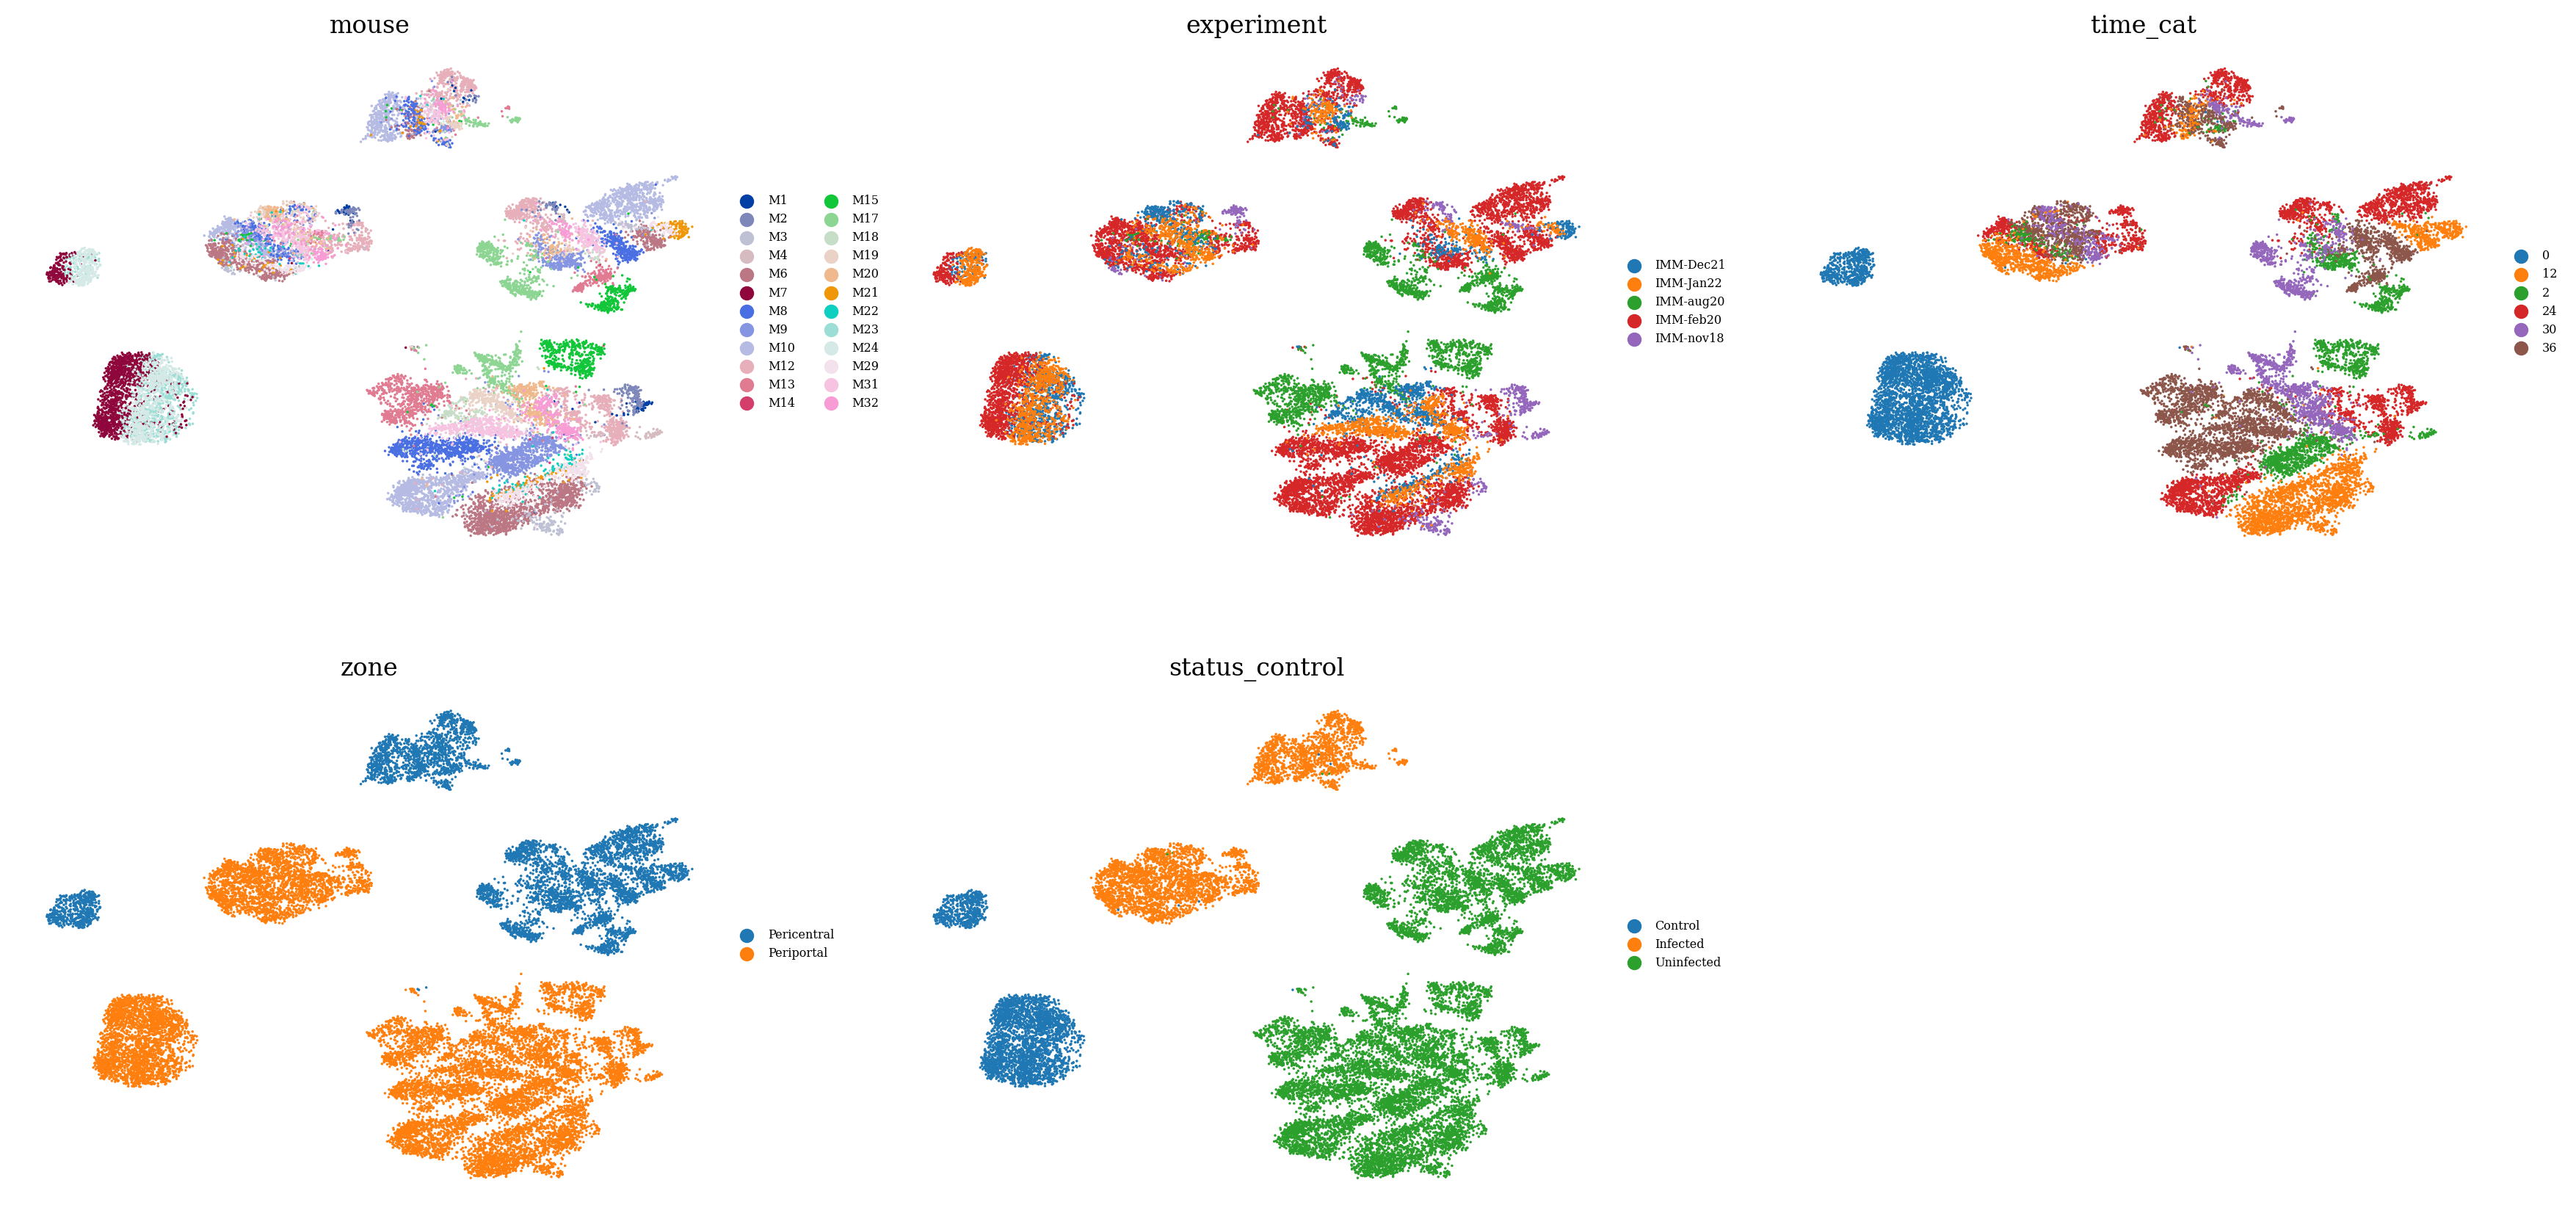

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

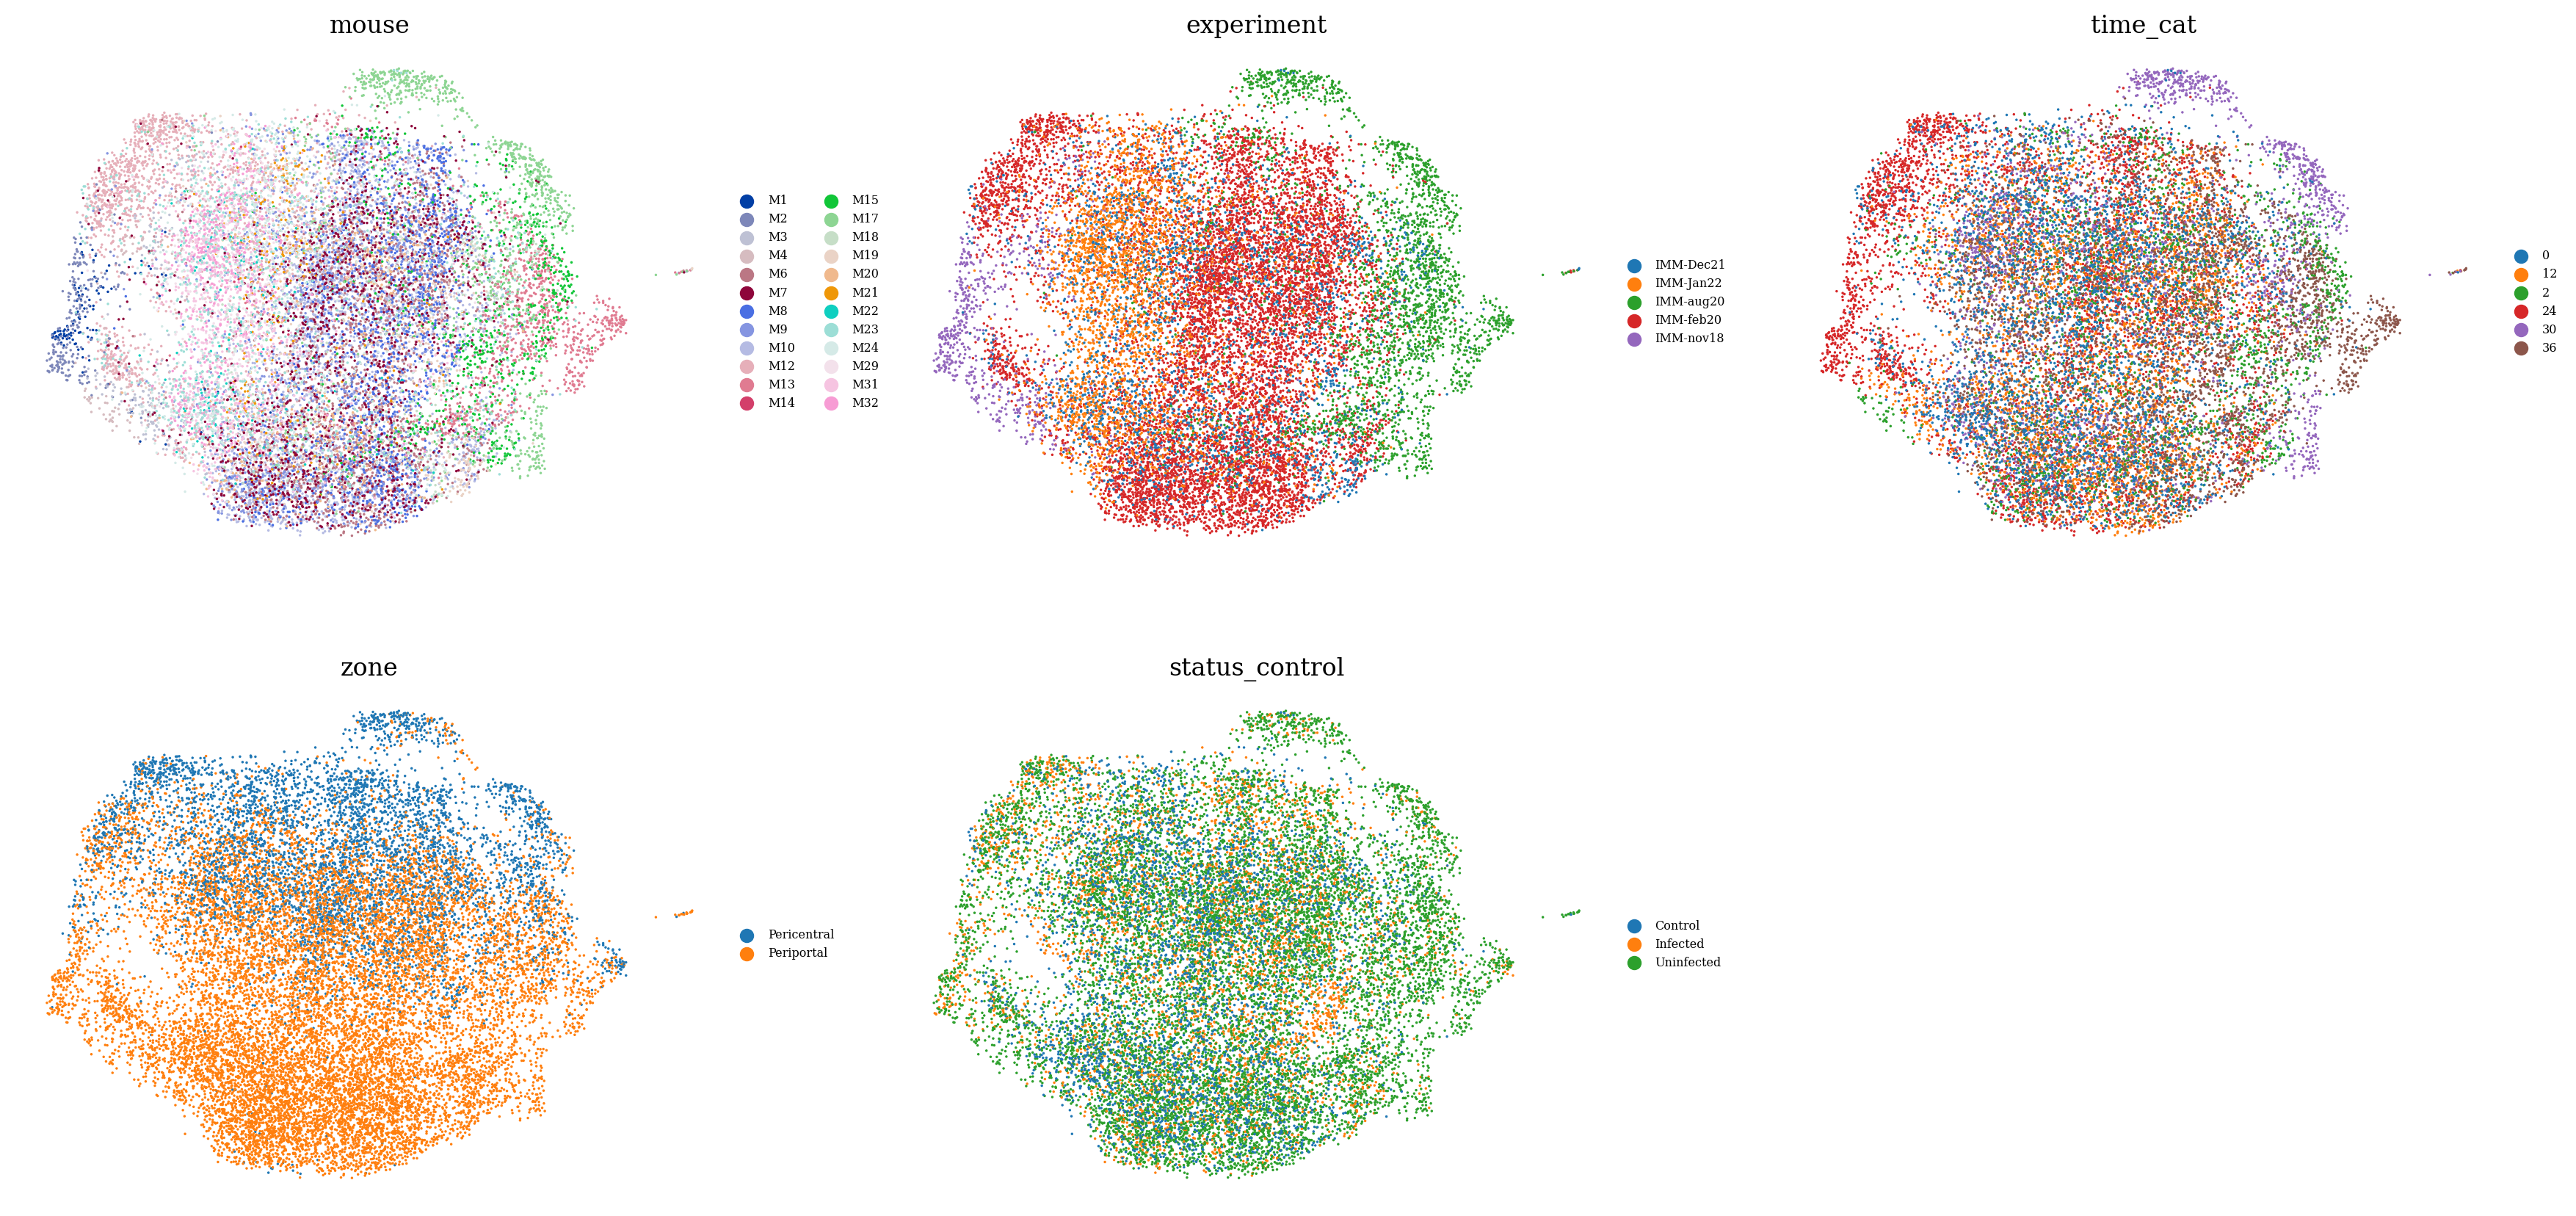

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 1/596 [00:00<03:46,  2.62it/s]

  1%|          | 4/596 [00:00<00:58, 10.07it/s]

  5%|▍         | 28/596 [00:00<00:07, 74.35it/s]

  9%|▊         | 52/596 [00:00<00:04, 121.37it/s]

 13%|█▎        | 75/596 [00:00<00:03, 152.37it/s]

 17%|█▋        | 99/596 [00:00<00:02, 177.03it/s]

 20%|██        | 122/596 [00:00<00:02, 191.25it/s]

 24%|██▍       | 145/596 [00:01<00:02, 201.56it/s]

 28%|██▊       | 168/596 [00:01<00:02, 207.67it/s]

 32%|███▏      | 191/596 [00:01<00:01, 212.94it/s]

 36%|███▌      | 214/596 [00:01<00:01, 216.60it/s]

 40%|███▉      | 237/596 [00:01<00:01, 219.13it/s]

 44%|████▎     | 260/596 [00:01<00:01, 219.82it/s]

 47%|████▋     | 283/596 [00:01<00:01, 221.16it/s]

 51%|█████▏    | 306/596 [00:01<00:01, 222.00it/s]

 55%|█████▌    | 330/596 [00:01<00:01, 224.85it/s]

 59%|█████▉    | 353/596 [00:02<00:01, 225.09it/s]

 63%|██████▎   | 376/596 [00:02<00:00, 223.08it/s]

 67%|██████▋   | 399/596 [00:02<00:00, 224.63it/s]

 71%|███████   | 422/596 [00:02<00:00, 224.80it/s]

 75%|███████▍  | 445/596 [00:02<00:00, 225.52it/s]

 79%|███████▊  | 468/596 [00:02<00:00, 225.80it/s]

 82%|████████▏ | 491/596 [00:02<00:00, 219.82it/s]

 86%|████████▌ | 514/596 [00:02<00:00, 222.31it/s]

 90%|█████████ | 537/596 [00:02<00:00, 223.18it/s]

 94%|█████████▍| 560/596 [00:02<00:00, 223.76it/s]

 98%|█████████▊| 584/596 [00:03<00:00, 225.81it/s]

100%|██████████| 596/596 [00:03<00:00, 192.00it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

In [23]:
np.mean(r2s)

0.9749847352732006

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)